#**BUSINESS APPLICATIONS OF ARTIFICIAL INTELLIGENCE**

**WORK PROJECT**

**GROUP USE A MASK!**

Members: Daniel Kim, Hikma Awol, Eduardo Savioli

Proposal: Build a classifier to recognize faces wearing masks based on a dataset of 853 png-format images.


**Instructions**

Brief instructions for using this notebook on your own Colaboratory environment:

1) go to https://www.kaggle.com/andrewmvd/face-mask-detection and download the data.

2) upload the unzipped data to a source directory in Colaboratory.

3) Create a target directory in Google drive to receive the training and the test files. 

4) Adjust source and target directories of the figures and xml files accordingly in the code.

5) Comment in code that creates new directories if this notebook is run for the first time. Then, comment them out.

6) Run the notebook

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.metrics import classification_report, confusion_matrix
# Import Keras libraries
import keras
from keras import utils
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir1 = '/content/drive/MyDrive/BusAppData/Facemaskdata/annotations/'
dir2 = '/content/drive/MyDrive/BusAppData/Facemaskdata/images/'
filelist1 =[]
for filename1 in os.listdir(dir1):
  filelist1.append(dir1+filename1)

Some information checks on the xml files. Also, a dataframe is generated where every image is syncronized with the correct label.

In [ ]:
imageinfo=[]
for xmlfile in filelist1:
  mask = 0
  nomask = 0
  maskincorrect =0
  tree = ET.parse(xmlfile)
  root = tree.getroot()
  fileindex = root.find('filename').text
  fileindexnumber = int(fileindex[12:-4])
  imagefilename = fileindex[:-3]+ 'png'
  for imagesize in root.findall('size'):
    width = imagesize.find('width').text
    height = imagesize.find('height').text
    pixels = int(width)*int(height)
  for people in root.findall('object'):
    status = people.find('name').text
    if status == 'without_mask':
      nomask = nomask+1
    elif status == 'with_mask':
      mask = mask+1
    elif status == 'mask_weared_incorrect':
      maskincorrect = maskincorrect+1      
  imageinfo.append([fileindexnumber, int(width), int(height), 
                    pixels, mask, nomask, maskincorrect, 
                    mask+nomask+maskincorrect, imagefilename])
dfaux = pd.DataFrame(imageinfo, columns = ['fileindex', 'width', 'height', 
                                          'pixels', 'mask', 'nomask', 
                                          'maskincorrect', 'numberofpeople', 
                                           'imagefilename'])
dfimageinfo = dfaux.sort_values(by=['fileindex'])
dfimageinfo.index = range(len(dfimageinfo)) # dataframe indexes now coincide with filename indexes

In [ ]:
print(dfimageinfo)

     fileindex  width  ...  numberofpeople        imagefilename
0            0    512  ...               3    maksssksksss0.png
1            1    400  ...               9    maksssksksss1.png
2            2    400  ...               4    maksssksksss2.png
3            3    400  ...               9    maksssksksss3.png
4            4    301  ...               1    maksssksksss4.png
..         ...    ...  ...             ...                  ...
848        848    400  ...               4  maksssksksss848.png
849        849    400  ...               4  maksssksksss849.png
850        850    400  ...               3  maksssksksss850.png
851        851    301  ...               1  maksssksksss851.png
852        852    267  ...               2  maksssksksss852.png

[853 rows x 9 columns]


In [ ]:
dfimageinfo.head()

,fileindex,width,height,pixels,mask,nomask,maskincorrect,numberofpeople,imagefilename
0,0,512,366,187392,1,2,0,3,maksssksksss0.png
1,1,400,156,62400,8,1,0,9,maksssksksss1.png
2,2,400,290,116000,3,0,1,4,maksssksksss2.png
3,3,400,271,108400,9,0,0,9,maksssksksss3.png
4,4,301,400,120400,1,0,0,1,maksssksksss4.png


The images have to be automatically copied to directories labeled as the class to which the image belong.

There should be 7 different classes, labeled as the following:

Class 1 = mask incorrect instances

Class 2 = no mask

Class 3 = mask incorrect + no mask

Class 4 = mask

Class 5 = mask + mask incorrect

Class 6 = mask + no mask

Class 7 = mask + no mask + mask incorrect


The number of individuals of the same instance on the same image will not change the label to which the image belongs. For example, two people wearing masks will belong to class #4.

The dataframe dfimageinfo will be appended to a new column indicating a class each image belongs.

In [ ]:
# Label text definition
labeltext = ['mask incorrect', 'no mask', 'mask incorrect + no mask', 
             'mask', 'mask + mask incorrect', 'mask + no mask', 
             'mask + no mask + mask incorrect']

Function Definitions:

Specific functions for this application will be defined below.

In [ ]:
# Functions to be used throughout the application
# Create an extra column with the label of each image
def classifyimage(dataframe):
  output=dataframe
  output['class'] = output.apply(lambda row: \
                                 generatelabel(row['mask'], \
                                               row['nomask'], \
                                               row['maskincorrect']), axis=1)
  return output

# Assign each image to its corresponding label.
def generatelabel(columnmask, columnnomask, columnincorrectmask):
  mask = False
  nomask = False
  incorrect = False
  if columnmask > 0:
    mask=True
  if columnnomask > 0:
    nomask = True
  if columnincorrectmask > 0:
    incorrect = True
  if mask==False and nomask==False and incorrect==True:
    output=1
  elif mask==False and nomask==True and incorrect==False:
    output=2
  elif mask==False and nomask==True and incorrect==True:
    output=3
  elif mask==True and nomask==False and incorrect==False:
    output=4
  elif mask==True and nomask==False and incorrect==True:
    output=5
  elif mask==True and nomask==True and incorrect==False:
    output=6
  elif mask==True and nomask==True and incorrect==True:
    output=7
  return output 

# Returns Train and Test sets in order to ensure that at least one instance
# of each class is represented in both sets.
def splitsets(dataframe, trainproportion):
  idx = pd.Index(dataframe['class'], name ='label')
  # Count the values for each class
  c1 = 0
  c2 = 0
  c3 = 0
  c4 = 0
  c5 = 0
  c6 = 0
  c7 = 0
  for i in idx:
    if i ==1:
      c1=c1+1
    elif i==2:
      c2=c2+1
    elif i==3:
      c3=c3+1
    elif i==4:
      c4=c4+1
    elif i==5:
      c5=c5+1
    elif i==6:
      c6=c6+1
    elif i==7:
      c7=c7+1
  frequencies=[c1, c2, c3, c4, c5, c6, c7]
  sampletraining = []
  imagelabel=0
  traindf = pd.DataFrame(columns = ['fileindex', 'label', 'filename'])
  testdf = pd.DataFrame(columns = ['fileindex', 'label', 'filename'])
  for j in frequencies:
    sampletraining.append(int(j*trainproportion))
  for trainsamples in sampletraining:
    imagelabel=imagelabel+1 # counts each class
    counter=0 # counts instances collected from a class
    linecounter=-1 # counts lines of the dataframe
    for label in dataframe['class']:
      linecounter=linecounter+1
      if label==imagelabel and counter<trainsamples:
        counter=counter+1
        traindf = traindf.append({'fileindex' : dataframe['fileindex'][linecounter],
                                  'label' : label, 
                                  'filename' : dataframe['imagefilename'][linecounter]}, 
                                 ignore_index = True)
      elif label==imagelabel and counter >= trainsamples:
        testdf = testdf.append({'fileindex' : dataframe['fileindex'][linecounter],
                                  'label' : label, 
                                  'filename' : dataframe['imagefilename'][linecounter]}, 
                                 ignore_index = True)
  return traindf, testdf

# Create labeled subdirectories under the training and test directories
def createlabeldirectories(inputdir):
  index=1
  labeldirectories=[]
  for i in range(1,8):
    labeldir = os.path.join(inputdir, 'label'+str(i))
    labeldirectories.append(labeldir)
    os.mkdir(labeldir) # Create directories
  return labeldirectories

# Copy all image files to their corresponding training and test directories
def copyimage2labeldirectory(sourcedir, destdir, imagelabel, dataframe):
    linecounter=-1 # counts lines of the dataframe
    for label in dataframe['label']:
      linecounter=linecounter+1
      if label==imagelabel:
        filename= dataframe['filename'][linecounter]
        originfile = os.path.join(sourcedir, filename)
        destinationdiraux = os.path.join(destdir, 'label'+str(label))
        destinationfile = os.path.join(destinationdiraux, filename)
        print('copying', originfile, 'to', destinationfile)
        shutil.copyfile(originfile, destinationfile)

# Return the predicted class, after reading the vector of probabilities 
# (softmax) at the output.
def predictedclass(softmaxprediction):
  j=0
  predlist=[]
  for vector in softmaxprediction:
    ind = np.argmax(vector)
    predlist.append(ind)
  output= np.array(predlist)
  return output

# Returns the accuracy (in percentage) of a confusion matrix
def accuracycalc(confusionmatrix):
  total = sum(sum(confusionmatrix))
  correct = sum(confusionmatrix.diagonal())
  output = 100*correct/total
  print("accuracy is ", "{:.2f}".format(output), "%.")
  return output

# Returns the match rate (in percentage) for each class taken 
# from a confusion matrix
def labelmatchrate(confusionmatrix, labels):
  nrows=confusionmatrix.shape[0]
  matchrate=[]
  for i in range(0,nrows):
    nelements = np.sum(confusionmatrix[i])
    correct = confusionmatrix[i][i]
    match = 100*correct/nelements
    matchrate.append(match)
    print("match for label", i+1, "(", labels[i],") is ", "{:.2f}".format(match), "%.")
  output = matchrate
  return output  

Based on columns 'mask', 'nomask' and 'maskincorrect', create an extra 'class' column assigning the class to which an image belong.

In [ ]:
dfimageinfo2 = classifyimage(dfimageinfo)
dfimageinfo2.head()

,fileindex,width,height,pixels,mask,nomask,maskincorrect,numberofpeople,imagefilename,class
0,0,512,366,187392,1,2,0,3,maksssksksss0.png,6
1,1,400,156,62400,8,1,0,9,maksssksksss1.png,6
2,2,400,290,116000,3,0,1,4,maksssksksss2.png,5
3,3,400,271,108400,9,0,0,9,maksssksksss3.png,4
4,4,301,400,120400,1,0,0,1,maksssksksss4.png,4


Count how many images are assigned to each class, to ensure that both training and test sets will have instances of all classes.

In [ ]:
frequencies = dfimageinfo2['class'].value_counts()
print(frequencies)

4    516
6    180
2     60
7     42
5     30
1     21
3      4
Name: class, dtype: int64


Based on class instances, the training and test split proportion will have to be at most 75%-25%, otherwise class 3 might not be represented in the test set.

Split into train and test sets will be done by means of a specific function that ensures the presence of at least one instance of each class in both sets.

In [ ]:
train, test = splitsets(dfimageinfo2, 0.75)
display(train)
display(test)

,fileindex,label,filename
0,24,1,maksssksksss24.png
1,112,1,maksssksksss112.png
2,132,1,maksssksksss132.png
3,258,1,maksssksksss258.png
4,272,1,maksssksksss272.png
...,...,...,...
633,613,7,maksssksksss613.png
634,623,7,maksssksksss623.png
635,627,7,maksssksksss627.png
636,634,7,maksssksksss634.png


,fileindex,label,filename
0,748,1,maksssksksss748.png
1,761,1,maksssksksss761.png
2,815,1,maksssksksss815.png
3,830,1,maksssksksss830.png
4,832,1,maksssksksss832.png
...,...,...,...
210,717,7,maksssksksss717.png
211,760,7,maksssksksss760.png
212,795,7,maksssksksss795.png
213,824,7,maksssksksss824.png


Confirm that in both sets all classes are represented.

In [ ]:
frequenciestrain = train['label'].value_counts()
frequenciestest = test['label'].value_counts()
print(frequenciestrain)
print(frequenciestest)

4    387
6    135
2     45
7     31
5     22
1     15
3      3
Name: label, dtype: int64
4    129
6     45
2     15
7     11
5      8
1      6
3      1
Name: label, dtype: int64


Verify correcteness of classification labels for each image by filtering images of any class and showing the correponding image, based on its file index.

In [ ]:
display(train[train['label']==2])

,fileindex,label,filename
15,14,2,maksssksksss14.png
16,48,2,maksssksksss48.png
17,51,2,maksssksksss51.png
18,68,2,maksssksksss68.png
19,72,2,maksssksksss72.png
20,95,2,maksssksksss95.png
21,121,2,maksssksksss121.png
22,125,2,maksssksksss125.png
23,128,2,maksssksksss128.png
24,154,2,maksssksksss154.png


(400, 267, 4)

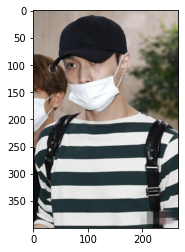

In [ ]:
filexindex = 835
imagepath = dir2 + dfimageinfo.iloc[filexindex][8]
image1 = plt.imread(imagepath)
plt.imshow(image1)
abc = image1.shape
abc

Preparation of the Dataset.

The images will be copied to their corresponding training and test directories, each of which having 7 subdirectories, one for each label to be identified by the CNN.
Labels for the subdirectories will be named label1 to label7.

In [ ]:
# This is the base work directory
baseworkdir = '/content/drive/MyDrive/BusAppData/Facemaskdata/workproject/'
traindir = os.path.join(baseworkdir, 'training')
testdir = os.path.join(baseworkdir, 'test')
# Create Train and Test directories (Comment out after directory is created)
#os.mkdir(baseworkdir)
#os.mkdir(traindir)
#os.mkdir(testdir)

# Create subdirectories label1 to label7 under Train and Test
# (Comment out after directories are created)
#createlabeldirectories(traindir)
#createlabeldirectories(testdir)

Copy training and test images to their corresponding directories.

In [ ]:
# After running this cell, comment it out.
#copyimage2labeldirectory(dir2, traindir, 1, train)
#copyimage2labeldirectory(dir2, traindir, 2, train)
#copyimage2labeldirectory(dir2, traindir, 3, train)
#copyimage2labeldirectory(dir2, traindir, 4, train)
#copyimage2labeldirectory(dir2, traindir, 5, train)
#copyimage2labeldirectory(dir2, traindir, 6, train)
#copyimage2labeldirectory(dir2, traindir, 7, train)

In [ ]:
# After running this cell, comment it out.
#copyimage2labeldirectory(dir2, testdir, 1, test)
#copyimage2labeldirectory(dir2, testdir, 2, test)
#copyimage2labeldirectory(dir2, testdir, 3, test)
#copyimage2labeldirectory(dir2, testdir, 4, test)
#copyimage2labeldirectory(dir2, testdir, 5, test)
#copyimage2labeldirectory(dir2, testdir, 6, test)
#copyimage2labeldirectory(dir2, testdir, 7, test)

**CONVOLUTIONAL NEURAL NETWORK DESIGN:**

Network design:



In [ ]:
#INITIALIZING THE CNN
classifier = Sequential()

# Load a pre-trained network VGG16
model = VGG16(include_top=False, input_shape=(224,224,3))

# Keep weights unchanged
for layer in model.layers:
  layer.trainable = False

# Add VGG16 into the CNN
classifier.add(model)

# Add a Flatten Layer
classifier.add(Flatten())

# Add a Dropout Layer
classifier.add(Dropout(0.5))

# Add a full connection layer
#classifier.add(Dense(units=128, activation='relu'))

# Other options of full connection layers
#classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=256, activation='relu'))
#classifier.add(Dense(units=512, activation='relu'))
#classifier.add(Dense(units=1024, activation='relu'))

# Add an output layer with 7 neurons
classifier.add(Dense(units=7, activation='softmax'))

# Compile the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 21,139,271
Trainable params: 6,424,583
Non-trainable params: 14,714,688
_________________________________________________________________


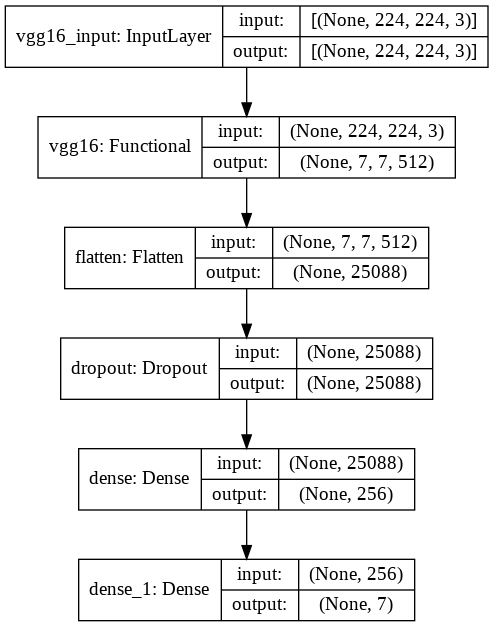

In [ ]:
from keras import utils
utils.plot_model(classifier, 
                 "/content/drive/MyDrive/Colab Notebooks/BusApp/preworkproject/bestcnn.png", 
                 show_shapes=True)

Treating the training data using augmentation.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 20, #0.2
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    )

train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(224,224),
    batch_size=10,
    class_mode='categorical',
    )

Found 638 images belonging to 7 classes.


Treating the test data without augmentation.

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    testdir,
    target_size=(224,224),
    batch_size=10,
    class_mode='categorical',
    )

Found 215 images belonging to 7 classes.


Training the classifier.

In [ ]:
steps=len(train_generator)//10
val_steps = len(test_generator)//10
history = classifier.fit(train_generator,
                         steps_per_epoch = steps,
                         epochs=200,
                         validation_data=test_generator,
                         validation_steps=val_steps)

Epoch 1/200
6/6 [==============================] - 2s 425ms/step - loss: 0.7254 - accuracy: 0.7333 - val_loss: 1.3065 - val_accuracy: 0.5000
Epoch 2/200
6/6 [==============================] - 2s 380ms/step - loss: 0.7344 - accuracy: 0.6667 - val_loss: 0.8543 - val_accuracy: 0.7000
Epoch 3/200
6/6 [==============================] - 2s 376ms/step - loss: 0.7219 - accuracy: 0.7333 - val_loss: 1.5120 - val_accuracy: 0.4000
Epoch 4/200
6/6 [==============================] - 2s 386ms/step - loss: 0.8383 - accuracy: 0.7000 - val_loss: 0.6085 - val_accuracy: 0.8000
Epoch 5/200
6/6 [==============================] - 2s 378ms/step - loss: 0.8498 - accuracy: 0.6000 - val_loss: 1.0488 - val_accuracy: 0.5000
Epoch 6/200
6/6 [==============================] - 2s 362ms/step - loss: 0.8043 - accuracy: 0.7000 - val_loss: 0.9807 - val_accuracy: 0.5000
Epoch 7/200
6/6 [==============================] - 2s 372ms/step - loss: 0.7271 - accuracy: 0.6667 - val_loss: 1.0022 - val_accuracy: 0.6000
Epoch 8/200
6

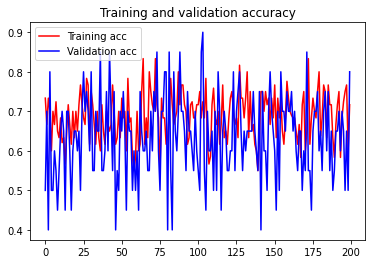

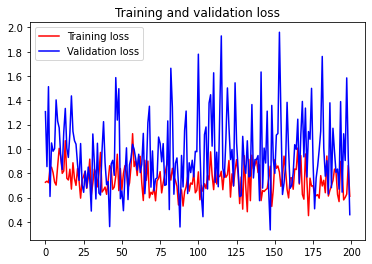

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

from matplotlib import pyplot as plt
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Testing the model and reporting the results on training and test images.

In [ ]:
classifier.evaluate(test_generator)

22/22 [==============================] - 4s 162ms/step - loss: 0.9251 - accuracy: 0.6558


[0.9250572323799133, 0.6558139324188232]

In [ ]:
#Confusion Matrix and Classification Report on Training Data
per = np.random.permutation(train_generator.n)
train_generator.index_array = per
classes = train_generator.classes[per]
Y_pred = classifier.predict(train_generator)
predictions = predictedclass(Y_pred) # These are the prediction labels from the training set

cmtrain = confusion_matrix(classes, predictions)
print('Confusion Matrix')
print(cmtrain)
acctrain = accuracycalc(cmtrain)
trainmatchrates = labelmatchrate(cmtrain, labeltext)
print('Classification Report')
target_names = ['1', '2', '3', '4', '5', '6', '7']
print(classification_report(classes, predictions, target_names=target_names))

Confusion Matrix
[[  9   0   0   6   0   0   0]
 [  0  33   0  12   0   0   0]
 [  0   0   1   1   1   0   0]
 [  1   0   0 339   0  46   1]
 [  0   0   0   8   8   6   0]
 [  0   0   0  53   1  81   0]
 [  0   0   0  10   1  13   7]]
accuracy is  74.92 %.
match for label 1 ( mask incorrect ) is  60.00 %.
match for label 2 ( no mask ) is  73.33 %.
match for label 3 ( mask incorrect + no mask ) is  33.33 %.
match for label 4 ( mask ) is  87.60 %.
match for label 5 ( mask + mask incorrect ) is  36.36 %.
match for label 6 ( mask + no mask ) is  60.00 %.
match for label 7 ( mask + no mask + mask incorrect ) is  22.58 %.
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.60      0.72        15
           2       1.00      0.73      0.85        45
           3       1.00      0.33      0.50         3
           4       0.79      0.88      0.83       387
           5       0.73      0.36      0.48        22
           6       0.55      

In [ ]:
#Confusion Matrix and Classification Report on Test Data
per = np.random.permutation(test_generator.n)
test_generator.index_array = per
classes = test_generator.classes[per]
Y_predtest = classifier.predict(test_generator)
predictionstest = predictedclass(Y_predtest) # These are the prediction labels from the test set

cmtest = confusion_matrix(classes, predictionstest)
print('Confusion Matrix')
print(cmtest)
acctest = accuracycalc(cmtest)
testmatchrates = labelmatchrate(cmtest, labeltext)
print('Classification Report')
target_names = ['1', '2', '3', '4', '5', '6', '7']
print(classification_report(classes, predictionstest, target_names=target_names))

Confusion Matrix
[[  3   0   0   3   0   0   0]
 [  0   9   0   6   0   0   0]
 [  0   0   0   1   0   0   0]
 [  0   0   0 113   0  15   1]
 [  0   0   0   5   1   2   0]
 [  0   0   0  30   0  14   1]
 [  0   0   0   6   0   4   1]]
accuracy is  65.58 %.
match for label 1 ( mask incorrect ) is  50.00 %.
match for label 2 ( no mask ) is  60.00 %.
match for label 3 ( mask incorrect + no mask ) is  0.00 %.
match for label 4 ( mask ) is  87.60 %.
match for label 5 ( mask + mask incorrect ) is  12.50 %.
match for label 6 ( mask + no mask ) is  31.11 %.
match for label 7 ( mask + no mask + mask incorrect ) is  9.09 %.
Classification Report
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         6
           2       1.00      0.60      0.75        15
           3       0.00      0.00      0.00         1
           4       0.69      0.88      0.77       129
           5       1.00      0.12      0.22         8
           6       0.40      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
